In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [60]:
import os

DATA_FOLDER = 'data'
SCRIPT_FOLDER = 'scripts'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

print('Archive found. Unzipping...')

Archive found. Unzipping...


In [61]:
if (is_archive_unzipped == False):
    !unzip data/archive.zip -d data

In [62]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip

In [63]:
if not os.path.exists('data/38-Cloud_test/test_gt'):
    print('Building test gt...')
    !python3 scripts/build_test_gt.py
    

Building test gt...
/home/happylemon/ailab/Sapienza-AI-Lab-Project
<class 'pandas.core.series.Series'>
LC08_L1TP_003052_20160120_20170405_01_T1
LC08_L1TP_018008_20160520_20170324_01_T1
LC08_L1TP_029032_20160720_20170222_01_T1
LC08_L1TP_029041_20160720_20170222_01_T1
LC08_L1TP_029044_20160720_20170222_01_T1
LC08_L1TP_032030_20160420_20170223_01_T1
LC08_L1TP_032035_20160420_20170223_01_T1
LC08_L1TP_032037_20160420_20170223_01_T1
LC08_L1TP_034029_20160520_20170223_01_T1
LC08_L1TP_034033_20160520_20170223_01_T1
LC08_L1TP_034037_20160520_20170223_01_T1
LC08_L1TP_035029_20160120_20170224_01_T1
LC08_L1TP_035035_20160120_20170224_01_T1
LC08_L1TP_039035_20160320_20170224_01_T1
LC08_L1TP_050024_20160520_20170324_01_T1
LC08_L1TP_063012_20160920_20170221_01_T1
LC08_L1TP_063013_20160920_20170221_01_T1
LC08_L1TP_064012_20160420_20170223_01_T1
LC08_L1TP_064015_20160420_20170223_01_T1
LC08_L1TP_066014_20160520_20170223_01_T1


In [64]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))
df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)
df_patches.head()

,name
0,patch_1_1_by_1_LC08_L1TP_002053_20160520_20170...
1,patch_1_1_by_1_LC08_L1TP_002054_20160520_20170...
2,patch_1_1_by_1_LC08_L1TP_011002_20160620_20170...
3,patch_1_1_by_1_LC08_L1TP_011247_20160620_20170...
4,patch_1_1_by_1_LC08_L1TP_029040_20160720_20170...


In [129]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, pytorch=True):
        super().__init__()

        self.patches = [self.map_patches(f) for f in patches_df['name']]
        self.pytorch = pytorch
        self.mean = None
        self.std = None

    def map_patches(self, file_name):

        train_path = Path(CLOUD_TRAIN_PATH)

        red_path = train_path / Path('train_red') / Path('red_' + file_name + '.TIF')
        green_path = train_path / Path('train_green') / Path('green_' + file_name + '.TIF')
        blue_path = train_path / Path('train_blue') / Path('blue_' + file_name + '.TIF')
        nir_path = train_path / Path('train_nir') / Path('nir_' + file_name + '.TIF')
        gt_path = train_path / Path('train_gt') / Path('gt_' + file_name + '.TIF')        

        return {
            'red' : red_path,
            'green' : green_path,
            'blue' : blue_path,
            'nir' : nir_path,
            'gt' : gt_path
        }   
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert:
            rgb = rgb.transpose((2, 0, 1))

        # temporary fix for normalization
        return rgb / np.iinfo(rgb.dtype).max
        return rgb        
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):
        x = torch.tensor(self.to_array(i, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.to_mask(i, add_dims=False), dtype=torch.float32)

        return x, y
        

In [134]:
data_train = Cloud38Dataset(df_patches_train)
print(f'Data has been loaded | Length: {len(data_train)}')

Data has been loaded | Length: 8400


[[0.39406424 0.38603799 0.40691234]
 [0.402533   0.39391165 0.41300069]
 [0.39923705 0.39005112 0.41292439]
 ...
 [0.45076677 0.43787289 0.45906767]
 [0.45215534 0.44061952 0.46048676]
 [0.44843214 0.43666743 0.45571069]]


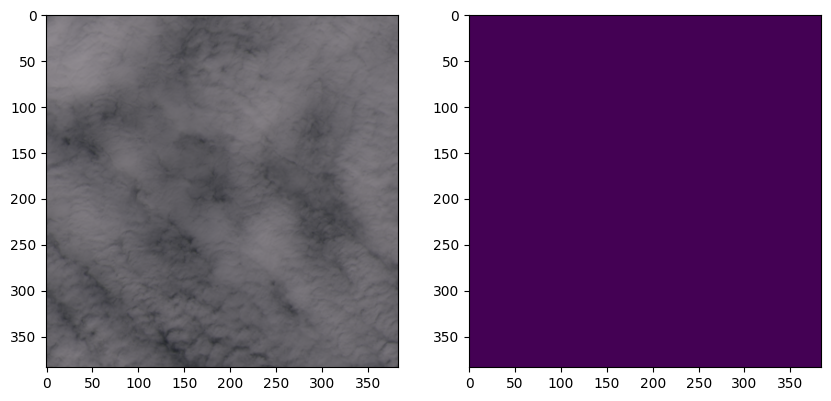

In [149]:
image_index = np.random.randint(0, len(data_train))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data_train.to_array(image_index, include_nir=False))
ax[1].imshow(data_train.to_mask(image_index))

print(data_train.to_array(image_index, include_nir=False)[0])

In [85]:
from torch.utils.data import DataLoader
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = 384

loader_train = DataLoader(data_train, batch_size=32)
print(loader_train)

psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for x, y in loader_train:
    psum += x.sum(axis=(0, 2, 3))
    psum_sq += (x ** 2).sum(axis=(0, 2, 3))

count = len(data_train) * IMAGE_SIZE * IMAGE_SIZE
mean = psum / count
var = (psum_sq / count) - (mean ** 2)
std = torch.sqrt(var)

print(f'Mean: {mean} | Std: {std}')

Mean: tensor([0.1482, 0.1461, 0.1549]) | Std: tensor([0.1631, 0.1587, 0.1664])


[[[0.50109102 0.48598459 0.51326772]
  [0.52620737 0.50914778 0.53881132]
  [0.53720912 0.52170596 0.54422827]
  ...
  [0.36678111 0.3585565  0.38379492]
  [0.38141451 0.37355612 0.39176013]
  [0.38600748 0.37914092 0.39647517]]

 [[0.50647745 0.4914931  0.52010376]
  [0.53044938 0.51338979 0.54235142]
  [0.54901961 0.53150225 0.55480278]
  ...
  [0.37291524 0.36534676 0.38582437]
  [0.37102312 0.36433967 0.39224842]
  [0.37976654 0.37181659 0.3971313 ]]

 [[0.51718929 0.50249485 0.52796216]
  [0.53559167 0.51718929 0.54561685]
  [0.5534905  0.53437095 0.56235599]
  ...
  [0.36806287 0.36217288 0.38194858]
  [0.38506142 0.3749752  0.39304189]
  [0.38831159 0.37901884 0.39760433]]

 ...

 [[0.36699474 0.35992981 0.38925765]
  [0.37633326 0.3709163  0.38725872]
  [0.3944152  0.38644999 0.40526436]
  ...
  [0.49880217 0.4827039  0.50312047]
  [0.50144198 0.48439765 0.50890364]
  [0.50457008 0.49010452 0.51570916]]

 [[0.37033646 0.36188296 0.38648051]
  [0.38039216 0.37415122 0.39575799]


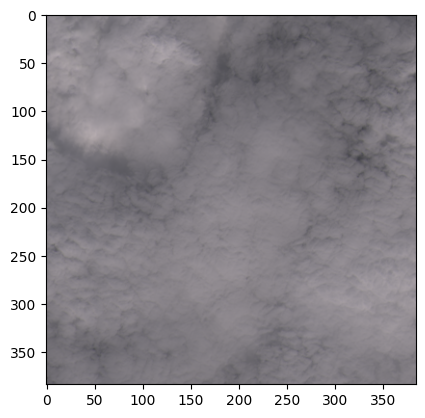

In [169]:
### TEMP

b_t = 'data/38-Cloud_training/train_blue/blue_patch_250_12_by_8_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'
g_t = 'data/38-Cloud_training/train_green/green_patch_250_12_by_8_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'
r_t = 'data/38-Cloud_training/train_red/red_patch_250_12_by_8_LC08_L1TP_061017_20160720_20170223_01_T1.TIF'

b = np.array(Image.open(b_t))
g = np.array(Image.open(g_t))
r = np.array(Image.open(r_t))

rgb = np.stack([r, g, b], axis=2)
rgb = rgb / np.iinfo(rgb.dtype).max
print(rgb)
plt.imshow(rgb)

/home/happylemon/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


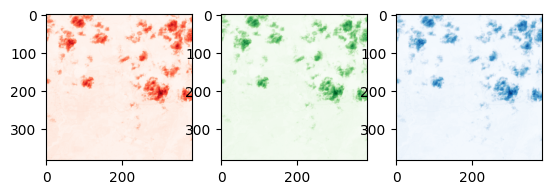

In [109]:
### Rasterio test

import rasterio
plt.subplot(1, 3, 1)
plt.imshow(rasterio.open(r_t).read(1), cmap='Reds')
plt.subplot(1, 3, 2)
plt.imshow(rasterio.open(g_t).read(1), cmap='Greens')
plt.subplot(1, 3, 3)
plt.imshow(rasterio.open(b_t).read(1), cmap='Blues')
